In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt


In [2]:
stack_fixed = 'MD657'
stack_moving = 'atlasV3'
classifier_setting = 30

In [3]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting, 
                                                   sided=False, volume_type='score')


File does not exist: /shared/CSHL_volumes/MD657/MD657_down32_annotationVolume/MD657_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp


Child returned 0
Child returned 1
0.43 seconds.
File does not exist: /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp && mkdir -p /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp


Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (530, 862, 367)


In [4]:
gradient_filepath_map_f = {ind_f: \
                           DataManager.get_volume_gradient_filepath_template(\
                            stack=stack_fixed, structure=struct_f, classifier_setting=classifier_setting)
                           for ind_f, struct_f in label_to_structure_fixed.iteritems()}

In [5]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

# for lm, s in volume_moving_structure_sizes.iteritems():
#     print label_to_name_moving[lm], s, 'voxels'

In [6]:
registration_settings

upstream_warp_id transform_type  terminate_thresh  \
warp_id                                                     
1                   None         affine          0.000010   
2                      1          rigid          0.000010   
4                      1          rigid          0.000001   
5                      1          rigid          0.000001   
6                      1         affine          0.000010   
7                   None          rigid          0.000001   
10                  None          rigid          0.000010   
11                     1         affine          0.000010   

         grad_computation_sample_number  grid_search_sample_number  std_tx  \
warp_id                                                                      
1                              100000.0                     1000.0     100   
2                              100000.0                    10000.0     100   
4                              100000.0                    10000.0     100   
5                              100000.0                    10000.0     100   
6                              100000.0                    10000.0     100   
7                              100000.0                     1000.0      50   
10                             100000.0                     1000.0     100   
11                             100000.0                    10000.0     100   

         std_ty  std_tz  std_theta_xy surround_weight  regularization_weight  
warp_id                                                                       
1           100     100            30               0                    NaN  
2           100     100            30               0                    NaN  
4           100     100            10               0               0.000001  
5           100     100            30         inverse               0.000000  
6           100     100            30            -0.5               0.000000  
7            50      50            10               0                    NaN  
10          100     100            30               0                    NaN  
11          100     100            30            -0.1               0.000000

In [7]:
warp_setting = 5

In [30]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    upstream_trial_idx = 3
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
# std_tx_um = warp_properties['std_tx']
# std_ty_um = warp_properties['std_ty']
# std_tz_um = warp_properties['std_tz']
std_tx = warp_properties['std_tx'] # in voxels
std_ty = warp_properties['std_ty']
std_tz = warp_properties['std_tz']
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy'])

reg_weight = warp_properties['regularization_weight']
reg_weights = np.ones((3,))*reg_weight

surround_weight = warp_properties['surround_weight']
include_surround = surround_weight != 0

upstream_warp_id                        1
transform_type                      rigid
terminate_thresh                    1e-06
grad_computation_sample_number     100000
grid_search_sample_number           10000
std_tx                                100
std_ty                                100
std_tz                                100
std_theta_xy                           30
surround_weight                   inverse
regularization_weight                   0
Name: 5, dtype: object


In [31]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 50
MAX_GRID_SEARCH_ITER_NUM = 30

In [32]:
lr1 = 10
lr2 = 0.1

# General Align Code

In [33]:
trial_num = 5

In [34]:
# for structure in all_known_structures_sided:
for structure in ['10N_L']:
# for structure in ['SNC_R']:

    try:
        if include_surround:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         trial_idx=upstream_trial_idx,
                                                                         structures=[structure, 
                                                                                     convert_to_surround_name(structure, margin='200')])
        else:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         trial_idx=upstream_trial_idx,
                                                                         structures=[structure])

        structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
        label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
        volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

        volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

        label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                             for label_m, name_m in label_to_structure_moving.iteritems()}

    #     label_weights_m = {label_m: surround_weight if 'surround' in name_m else 1. \
    #                        for label_m, name_m in label_to_structure_moving.iteritems()}

        label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                           /float(volume_moving_structure_sizes[label_m])
                           if 'surround' in name_m else 1. \
                           for label_m, name_m in label_to_structure_moving.iteritems()}

        aligner = Aligner4(volume_fixed, volume_moving, 
                           labelIndexMap_m2f=label_mapping_m2f)

        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                             indices_m=[structure_to_label_moving[structure]])                            

        aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

        aligner.set_regularization_weights(reg_weights)
        aligner.set_label_weights(label_weights_m)

#         std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#         std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#         std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)

        T_all_trials = []
        scores_all_trials = []

        for trial_idx in range(trial_num):

            T, scores = aligner.optimize(type=transform_type, 
                                         max_iter_num=MAX_ITER_NUM, 
                                         history_len=HISTORY_LEN, 
                                         terminate_thresh=terminate_thresh,
                                         grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM,
                                         grid_search_sample_number=grid_search_sample_number,
                                         grad_computation_sample_number=grad_computation_sample_number,
                                         lr1=lr1, lr2=lr2,
                                        std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)

    #         print T.reshape((3,4))
    #         plt.figure();
    #         plt.plot(scores);
    #         plt.show();
    #         print max(scores), scores[-1]

            T_all_trials.append(T)
            scores_all_trials.append(scores)

#             params_fp = \
#             DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                           classifier_setting_m=classifier_setting,
#                                                           classifier_setting_f=classifier_setting,
#                                                           warp_setting=warp_setting,
#                                                           param_suffix=structure,
#                                                           trial_idx=trial_idx)
#             create_parent_dir_if_not_exists(params_fp)
#             DataManager.save_alignment_parameters(params_fp, T, 
#                                                   aligner.centroid_m, aligner.centroid_f,
#                                                   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#                                                   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

            
#             history_fp = DataManager.get_score_history_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                           classifier_setting_m=classifier_setting,
#                                                           classifier_setting_f=classifier_setting,
#                                                           warp_setting=warp_setting,
#                                                           param_suffix=structure,
#                                                           trial_idx=trial_idx)
#             bp.pack_ndarray_file(np.array(scores), history_fp)
            
#             score_plot_fp = \
#             DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                           classifier_setting_m=classifier_setting,
#                                                           classifier_setting_f=classifier_setting,
#                                                           warp_setting=warp_setting,
#                                                           param_suffix=structure,
#                                                           trial_idx=trial_idx)
#             fig = plt.figure();
#             plt.plot(scores);
#             plt.savefig(score_plot_fp, bbox_inches='tight')
#             plt.close(fig)

#             upload_from_ec2_to_s3(history_fp)
#             upload_from_ec2_to_s3(params_fp)
#             upload_from_ec2_to_s3(score_plot_fp)

    except Exception as e:
        sys.stderr.write('%s\n' % e)
        sys.stderr.write('Error transforming volume %s.\n' % structure)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 409.64260186  301.17857994  152.2312366 ] f: [ 409.64260186  301.17857994  152.2312366 ]
set([1])


load gradient 1: 11.582932 seconds
overall: 11.583042 seconds
grid search: 8.284414 seconds
tx_best: 5.48 (voxel), ty_best: 4.70, tz_best: 6.77, theta_xy_best: -26.01 (deg)
sigma_tx: 6.79 (voxel), sigma_ty: 6.79, sigma_tz: 6.79, sigma_theta_xy: 30.00 (deg)
-inf 0.000067
iteration 0
step: 0.05 seconds
score: 0.000067
iteration 1
step: 0.04 seconds
score: -0.000002
iteration 2
step: 0.04 seconds
score: 0.000054
iteration 3
step: 0.04 seconds
score: 0.000051
iteration 4


params_best_upToNow [ 5.4788854   4.69888161  6.77142067 -0.45396781]


step: 0.04 seconds
score: 0.000046
iteration 5
step: 0.04 seconds
score: 0.000056
iteration 6
step: 0.04 seconds
score: 0.000056
iteration 7
step: 0.04 seconds
score: 0.000055
iteration 8
step: 0.04 seconds
score: 0.000061
iteration 9
step: 0.04 seconds
score: 0.000068
iteration 10
step: 0.04 seconds
score: 0.000073
iteration 11
step: 0.04 seconds
score: 0.000080
iteration 12
step: 0.04 seconds
score: 0.000088
iteration 13
step: 0.04 seconds
score: 0.000065
iteration 14
step: 0.04 seconds
score: 0.000080
iteration 15
step: 0.04 seconds
score: 0.000086
iteration 16
step: 0.04 seconds
score: 0.000077
iteration 17
step: 0.04 seconds
score: 0.000084
iteration 18
step: 0.04 seconds
score: 0.000072
iteration 19
step: 0.04 seconds
score: 0.000079
iteration 20
step: 0.04 seconds
score: 0.000084
iteration 21
step: 0.04 seconds
score: 0.000076
iteration 22
step: 0.04 seconds
score: 0.000081
iteration 23
step: 0.04 seconds
score: 0.000083
iteration 24
step: 0.04 seconds
score: 0.000081
iteration 

step: 0.04 seconds
score: 0.000098
iteration 175
step: 0.04 seconds
score: 0.000098
iteration 176
step: 0.04 seconds
score: 0.000100
iteration 177
step: 0.04 seconds
score: 0.000099
iteration 178
step: 0.04 seconds
score: 0.000102
iteration 179
step: 0.04 seconds
score: 0.000100
iteration 180
step: 0.04 seconds
score: 0.000099
iteration 181
step: 0.04 seconds
score: 0.000100
iteration 182
step: 0.04 seconds
score: 0.000099
iteration 183
step: 0.04 seconds
score: 0.000100
iteration 184
step: 0.04 seconds
score: 0.000100
iteration 185
step: 0.04 seconds
score: 0.000101
iteration 186
step: 0.04 seconds
score: 0.000101
iteration 187
step: 0.04 seconds
score: 0.000104
iteration 188
step: 0.04 seconds
score: 0.000103
iteration 189
step: 0.04 seconds
score: 0.000104
iteration 190
step: 0.04 seconds
score: 0.000102
iteration 191
step: 0.04 seconds
score: 0.000102
iteration 192
step: 0.04 seconds
score: 0.000100
iteration 193
step: 0.04 seconds
score: 0.000102
iteration 194
step: 0.04 seconds
s

params_best_upToNow [ 6.64112533  1.53924573  6.12133625 -0.40290351]


step: 0.04 seconds
score: 0.000067
iteration 5
step: 0.04 seconds
score: 0.000060
iteration 6
step: 0.04 seconds
score: 0.000081
iteration 7
step: 0.04 seconds
score: 0.000075
iteration 8
step: 0.04 seconds
score: 0.000075
iteration 9
step: 0.04 seconds
score: 0.000076
iteration 10
step: 0.04 seconds
score: 0.000078
iteration 11
step: 0.04 seconds
score: 0.000078
iteration 12
step: 0.04 seconds
score: 0.000083
iteration 13
step: 0.04 seconds
score: 0.000087
iteration 14
step: 0.04 seconds
score: 0.000082
iteration 15
step: 0.04 seconds
score: 0.000088
iteration 16
step: 0.04 seconds
score: 0.000085
iteration 17
step: 0.04 seconds
score: 0.000083
iteration 18
step: 0.04 seconds
score: 0.000085
iteration 19
step: 0.04 seconds
score: 0.000086
iteration 20
step: 0.04 seconds
score: 0.000079
iteration 21
step: 0.04 seconds
score: 0.000079
iteration 22
step: 0.04 seconds
score: 0.000089
iteration 23
step: 0.04 seconds
score: 0.000082
iteration 24
step: 0.04 seconds
score: 0.000085
iteration 

step: 0.04 seconds
score: 0.000101
iteration 175
step: 0.04 seconds
score: 0.000100
iteration 176
step: 0.04 seconds
score: 0.000100
iteration 177
step: 0.04 seconds
score: 0.000103
iteration 178
step: 0.04 seconds
score: 0.000101
iteration 179
step: 0.04 seconds
score: 0.000103
iteration 180
step: 0.04 seconds
score: 0.000102
iteration 181
step: 0.04 seconds
score: 0.000101
iteration 182
step: 0.04 seconds
score: 0.000100
iteration 183
step: 0.04 seconds
score: 0.000101
iteration 184
step: 0.04 seconds
score: 0.000101
iteration 185
step: 0.04 seconds
score: 0.000102
iteration 186
step: 0.04 seconds
score: 0.000102
iteration 187
step: 0.04 seconds
score: 0.000102
iteration 188
step: 0.04 seconds
score: 0.000102
iteration 189
step: 0.04 seconds
score: 0.000101
iteration 190
step: 0.04 seconds
score: 0.000101
iteration 191
step: 0.04 seconds
score: 0.000101
iteration 192
step: 0.04 seconds
score: 0.000103
iteration 193
step: 0.04 seconds
score: 0.000103
iteration 194
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000123
iteration 345
step: 0.04 seconds
score: 0.000125
iteration 346
step: 0.04 seconds
score: 0.000124
iteration 347
step: 0.04 seconds
score: 0.000123
iteration 348
step: 0.04 seconds
score: 0.000122
iteration 349
step: 0.04 seconds
score: 0.000123
iteration 350
step: 0.04 seconds
score: 0.000125
iteration 351
step: 0.04 seconds
score: 0.000123
iteration 352
step: 0.04 seconds
score: 0.000124
iteration 353
step: 0.04 seconds
score: 0.000124
iteration 354
step: 0.04 seconds
score: 0.000124
iteration 355
step: 0.04 seconds
score: 0.000124
iteration 356
step: 0.04 seconds
score: 0.000124
iteration 357
step: 0.04 seconds
score: 0.000124
iteration 358
step: 0.04 seconds
score: 0.000125
iteration 359
step: 0.04 seconds
score: 0.000127
iteration 360
step: 0.04 seconds
score: 0.000128
iteration 361
step: 0.04 seconds
score: 0.000127
iteration 362
step: 0.04 seconds
score: 0.000126
iteration 363
step: 0.04 seconds
score: 0.000127
iteration 364
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000153
iteration 515
step: 0.04 seconds
score: 0.000154
iteration 516
step: 0.04 seconds
score: 0.000153
iteration 517
step: 0.04 seconds
score: 0.000155
iteration 518
step: 0.04 seconds
score: 0.000152
iteration 519
step: 0.04 seconds
score: 0.000153
iteration 520
step: 0.04 seconds
score: 0.000154
iteration 521
step: 0.04 seconds
score: 0.000156
iteration 522
step: 0.04 seconds
score: 0.000157
iteration 523
step: 0.04 seconds
score: 0.000157
iteration 524
step: 0.04 seconds
score: 0.000153
iteration 525
step: 0.04 seconds
score: 0.000156
iteration 526
step: 0.04 seconds
score: 0.000156
iteration 527
step: 0.04 seconds
score: 0.000158
iteration 528
step: 0.04 seconds
score: 0.000159
iteration 529
step: 0.04 seconds
score: 0.000159
iteration 530
step: 0.04 seconds
score: 0.000158
iteration 531
step: 0.04 seconds
score: 0.000157
iteration 532
step: 0.04 seconds
score: 0.000155
iteration 533
step: 0.04 seconds
score: 0.000159
iteration 534
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000174
iteration 685
step: 0.04 seconds
score: 0.000172
iteration 686
step: 0.04 seconds
score: 0.000175
iteration 687
step: 0.04 seconds
score: 0.000172
iteration 688
step: 0.04 seconds
score: 0.000173
iteration 689
step: 0.04 seconds
score: 0.000174
iteration 690
step: 0.04 seconds
score: 0.000175
iteration 691
step: 0.04 seconds
score: 0.000173
iteration 692
step: 0.04 seconds
score: 0.000174
iteration 693
step: 0.04 seconds
score: 0.000173
iteration 694
step: 0.04 seconds
score: 0.000173
iteration 695
step: 0.04 seconds
score: 0.000174
iteration 696
step: 0.04 seconds
score: 0.000175
iteration 697
step: 0.04 seconds
score: 0.000176
iteration 698
step: 0.04 seconds
score: 0.000174
iteration 699
step: 0.04 seconds
score: 0.000175
iteration 700
step: 0.04 seconds
score: 0.000175
iteration 701
step: 0.05 seconds
score: 0.000175
iteration 702
step: 0.04 seconds
score: 0.000174
iteration 703
step: 0.04 seconds
score: 0.000177
iteration 704
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000212
iteration 855
step: 0.04 seconds
score: 0.000211
iteration 856
step: 0.04 seconds
score: 0.000212
iteration 857
step: 0.04 seconds
score: 0.000215
iteration 858
step: 0.04 seconds
score: 0.000211
iteration 859
step: 0.04 seconds
score: 0.000216
iteration 860
step: 0.04 seconds
score: 0.000216
iteration 861
step: 0.04 seconds
score: 0.000219
iteration 862
step: 0.04 seconds
score: 0.000221
iteration 863
step: 0.04 seconds
score: 0.000222
iteration 864
step: 0.04 seconds
score: 0.000221
iteration 865
step: 0.04 seconds
score: 0.000223
iteration 866
step: 0.04 seconds
score: 0.000224
iteration 867
step: 0.04 seconds
score: 0.000225
iteration 868
step: 0.04 seconds
score: 0.000222
iteration 869
step: 0.04 seconds
score: 0.000226
iteration 870
step: 0.04 seconds
score: 0.000228
iteration 871
step: 0.04 seconds
score: 0.000229
iteration 872
step: 0.04 seconds
score: 0.000227
iteration 873
step: 0.04 seconds
score: 0.000231
iteration 874
step: 0.04 seconds
s

params_best_upToNow [ 6.65005391 -0.58716618  6.54833592 -0.32302548]


step: 0.04 seconds
score: 0.000051
iteration 5
step: 0.04 seconds
score: 0.000043
iteration 6
step: 0.04 seconds
score: 0.000053
iteration 7
step: 0.04 seconds
score: 0.000064
iteration 8
step: 0.04 seconds
score: 0.000071
iteration 9
step: 0.04 seconds
score: 0.000071
iteration 10
step: 0.04 seconds
score: 0.000077
iteration 11
step: 0.04 seconds
score: 0.000079
iteration 12
step: 0.04 seconds
score: 0.000080
iteration 13
step: 0.04 seconds
score: 0.000078
iteration 14
step: 0.04 seconds
score: 0.000082
iteration 15
step: 0.04 seconds
score: 0.000083
iteration 16
step: 0.04 seconds
score: 0.000080
iteration 17
step: 0.04 seconds
score: 0.000082
iteration 18
step: 0.04 seconds
score: 0.000080
iteration 19
step: 0.04 seconds
score: 0.000080
iteration 20
step: 0.04 seconds
score: 0.000080
iteration 21
step: 0.04 seconds
score: 0.000082
iteration 22
step: 0.04 seconds
score: 0.000081
iteration 23
step: 0.04 seconds
score: 0.000081
iteration 24
step: 0.04 seconds
score: 0.000081
iteration 

step: 0.04 seconds
score: 0.000123
iteration 175
step: 0.04 seconds
score: 0.000121
iteration 176
step: 0.04 seconds
score: 0.000123
iteration 177
step: 0.04 seconds
score: 0.000126
iteration 178
step: 0.04 seconds
score: 0.000123
iteration 179
step: 0.04 seconds
score: 0.000123
iteration 180
step: 0.04 seconds
score: 0.000123
iteration 181
step: 0.04 seconds
score: 0.000124
iteration 182
step: 0.04 seconds
score: 0.000126
iteration 183
step: 0.04 seconds
score: 0.000123
iteration 184
step: 0.04 seconds
score: 0.000125
iteration 185
step: 0.04 seconds
score: 0.000125
iteration 186
step: 0.04 seconds
score: 0.000126
iteration 187
step: 0.04 seconds
score: 0.000124
iteration 188
step: 0.04 seconds
score: 0.000124
iteration 189
step: 0.04 seconds
score: 0.000122
iteration 190
step: 0.04 seconds
score: 0.000129
iteration 191
step: 0.04 seconds
score: 0.000123
iteration 192
step: 0.04 seconds
score: 0.000124
iteration 193
step: 0.04 seconds
score: 0.000123
iteration 194
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000159
iteration 345
step: 0.04 seconds
score: 0.000150
iteration 346
step: 0.04 seconds
score: 0.000156
iteration 347
step: 0.04 seconds
score: 0.000158
iteration 348
step: 0.04 seconds
score: 0.000156
iteration 349
step: 0.04 seconds
score: 0.000157
iteration 350
step: 0.04 seconds
score: 0.000158
iteration 351
step: 0.04 seconds
score: 0.000158
iteration 352
step: 0.04 seconds
score: 0.000152
iteration 353
step: 0.04 seconds
score: 0.000155
iteration 354
step: 0.04 seconds
score: 0.000157
iteration 355
step: 0.04 seconds
score: 0.000157
iteration 356
step: 0.04 seconds
score: 0.000156
iteration 357
step: 0.04 seconds
score: 0.000156
iteration 358
step: 0.04 seconds
score: 0.000158
iteration 359
step: 0.04 seconds
score: 0.000158
iteration 360
step: 0.04 seconds
score: 0.000160
iteration 361
step: 0.04 seconds
score: 0.000155
iteration 362
step: 0.04 seconds
score: 0.000154
iteration 363
step: 0.04 seconds
score: 0.000157
iteration 364
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000171
iteration 515
step: 0.04 seconds
score: 0.000171
iteration 516
step: 0.04 seconds
score: 0.000171
iteration 517
step: 0.04 seconds
score: 0.000175
iteration 518
step: 0.04 seconds
score: 0.000172
iteration 519
step: 0.04 seconds
score: 0.000171
iteration 520
step: 0.04 seconds
score: 0.000171
iteration 521
step: 0.04 seconds
score: 0.000174
iteration 522
step: 0.04 seconds
score: 0.000173
iteration 523
step: 0.04 seconds
score: 0.000173
iteration 524
step: 0.04 seconds
score: 0.000173
iteration 525
step: 0.04 seconds
score: 0.000175
iteration 526
step: 0.04 seconds
score: 0.000172
iteration 527
step: 0.04 seconds
score: 0.000174
iteration 528
step: 0.04 seconds
score: 0.000171
iteration 529
step: 0.04 seconds
score: 0.000172
iteration 530
step: 0.04 seconds
score: 0.000176
iteration 531
step: 0.04 seconds
score: 0.000172
iteration 532
step: 0.04 seconds
score: 0.000176
iteration 533
step: 0.04 seconds
score: 0.000171
iteration 534
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000224
iteration 685
step: 0.04 seconds
score: 0.000225
iteration 686
step: 0.04 seconds
score: 0.000226
iteration 687
step: 0.04 seconds
score: 0.000227
iteration 688
step: 0.04 seconds
score: 0.000228
iteration 689
step: 0.04 seconds
score: 0.000228
iteration 690
step: 0.04 seconds
score: 0.000227
iteration 691
step: 0.04 seconds
score: 0.000234
iteration 692
step: 0.04 seconds
score: 0.000233
iteration 693
step: 0.04 seconds
score: 0.000231
iteration 694
step: 0.04 seconds
score: 0.000231
iteration 695
step: 0.04 seconds
score: 0.000233
iteration 696
step: 0.04 seconds
score: 0.000232
iteration 697
step: 0.04 seconds
score: 0.000235
iteration 698
step: 0.04 seconds
score: 0.000233
iteration 699
step: 0.04 seconds
score: 0.000235
iteration 700
step: 0.04 seconds
score: 0.000235
iteration 701
step: 0.04 seconds
score: 0.000238
iteration 702
step: 0.04 seconds
score: 0.000236
iteration 703
step: 0.04 seconds
score: 0.000239
iteration 704
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000283
iteration 855
step: 0.04 seconds
score: 0.000284
iteration 856
step: 0.04 seconds
score: 0.000288
iteration 857
step: 0.04 seconds
score: 0.000287
iteration 858
step: 0.04 seconds
score: 0.000284
iteration 859
step: 0.04 seconds
score: 0.000287
iteration 860
step: 0.04 seconds
score: 0.000284
iteration 861
step: 0.04 seconds
score: 0.000288
iteration 862
step: 0.04 seconds
score: 0.000287
iteration 863
step: 0.04 seconds
score: 0.000284
iteration 864
step: 0.04 seconds
score: 0.000286
iteration 865
step: 0.04 seconds
score: 0.000287
iteration 866
step: 0.04 seconds
score: 0.000288
iteration 867
step: 0.04 seconds
score: 0.000287
iteration 868
step: 0.04 seconds
score: 0.000287
iteration 869
step: 0.04 seconds
score: 0.000287
iteration 870
step: 0.04 seconds
score: 0.000285
iteration 871
step: 0.04 seconds
score: 0.000288
iteration 872
step: 0.04 seconds
score: 0.000284
iteration 873
step: 0.04 seconds
score: 0.000287
iteration 874
step: 0.04 seconds
s

params_best_upToNow [ 5.78286239  5.7922226   6.35699217 -0.46642439]


step: 0.05 seconds
score: 0.000052
iteration 4
step: 0.05 seconds
score: 0.000059
iteration 5
step: 0.05 seconds
score: 0.000061
iteration 6
step: 0.05 seconds
score: 0.000060
iteration 7
step: 0.05 seconds
score: 0.000061
iteration 8
step: 0.05 seconds
score: 0.000063
iteration 9
step: 0.05 seconds
score: 0.000074
iteration 10
step: 0.05 seconds
score: 0.000072
iteration 11
step: 0.05 seconds
score: 0.000074
iteration 12
step: 0.05 seconds
score: 0.000076
iteration 13
step: 0.05 seconds
score: 0.000079
iteration 14
step: 0.05 seconds
score: 0.000080
iteration 15
step: 0.05 seconds
score: 0.000076
iteration 16
step: 0.05 seconds
score: 0.000079
iteration 17
step: 0.05 seconds
score: 0.000077
iteration 18
step: 0.05 seconds
score: 0.000079
iteration 19
step: 0.05 seconds
score: 0.000076
iteration 20
step: 0.05 seconds
score: 0.000083
iteration 21
step: 0.05 seconds
score: 0.000073
iteration 22
step: 0.05 seconds
score: 0.000071
iteration 23
step: 0.05 seconds
score: 0.000073
iteration 2

step: 0.05 seconds
score: 0.000097
iteration 174
step: 0.05 seconds
score: 0.000098
iteration 175
step: 0.05 seconds
score: 0.000100
iteration 176
step: 0.05 seconds
score: 0.000098
iteration 177
step: 0.05 seconds
score: 0.000098
iteration 178
step: 0.05 seconds
score: 0.000100
iteration 179
step: 0.05 seconds
score: 0.000098
iteration 180
step: 0.05 seconds
score: 0.000101
iteration 181
step: 0.05 seconds
score: 0.000097
iteration 182
step: 0.05 seconds
score: 0.000100
iteration 183
step: 0.05 seconds
score: 0.000098
iteration 184
step: 0.05 seconds
score: 0.000098
iteration 185
step: 0.05 seconds
score: 0.000100
iteration 186
step: 0.05 seconds
score: 0.000098
iteration 187
step: 0.05 seconds
score: 0.000097
iteration 188
step: 0.05 seconds
score: 0.000098
iteration 189
step: 0.05 seconds
score: 0.000098
iteration 190
step: 0.05 seconds
score: 0.000096
iteration 191
step: 0.05 seconds
score: 0.000098
iteration 192
step: 0.05 seconds
score: 0.000101
iteration 193
step: 0.05 seconds
s

step: 0.05 seconds
score: 0.000111
iteration 344
step: 0.05 seconds
score: 0.000113
iteration 345
step: 0.05 seconds
score: 0.000111
iteration 346
step: 0.05 seconds
score: 0.000111
iteration 347
step: 0.05 seconds
score: 0.000112
iteration 348
step: 0.05 seconds
score: 0.000113
iteration 349
step: 0.05 seconds
score: 0.000114
iteration 350
step: 0.05 seconds
score: 0.000112
iteration 351
step: 0.05 seconds
score: 0.000113
iteration 352
step: 0.05 seconds
score: 0.000112
iteration 353
step: 0.05 seconds
score: 0.000112
iteration 354
step: 0.05 seconds
score: 0.000112
iteration 355
step: 0.05 seconds
score: 0.000114
iteration 356
step: 0.05 seconds
score: 0.000115
iteration 357
step: 0.05 seconds
score: 0.000114
iteration 358
step: 0.05 seconds
score: 0.000113
iteration 359
step: 0.05 seconds
score: 0.000114
iteration 360
step: 0.05 seconds
score: 0.000115
iteration 361
step: 0.05 seconds
score: 0.000113
iteration 362
step: 0.05 seconds
score: 0.000114
iteration 363
step: 0.05 seconds
s

step: 0.05 seconds
score: 0.000130
iteration 514
step: 0.05 seconds
score: 0.000131
iteration 515
step: 0.05 seconds
score: 0.000132
iteration 516
step: 0.05 seconds
score: 0.000131
iteration 517
step: 0.05 seconds
score: 0.000131
iteration 518
step: 0.05 seconds
score: 0.000131
iteration 519
step: 0.05 seconds
score: 0.000133
iteration 520
step: 0.05 seconds
score: 0.000131
iteration 521
step: 0.05 seconds
score: 0.000132
iteration 522
step: 0.05 seconds
score: 0.000133
iteration 523
step: 0.05 seconds
score: 0.000135
iteration 524
step: 0.05 seconds
score: 0.000133
iteration 525
step: 0.05 seconds
score: 0.000135
iteration 526
step: 0.05 seconds
score: 0.000134
iteration 527
step: 0.05 seconds
score: 0.000133
iteration 528
step: 0.05 seconds
score: 0.000133
iteration 529
step: 0.05 seconds
score: 0.000134
iteration 530
step: 0.05 seconds
score: 0.000136
iteration 531
step: 0.05 seconds
score: 0.000136
iteration 532
step: 0.05 seconds
score: 0.000133
iteration 533
step: 0.05 seconds
s

step: 0.05 seconds
score: 0.000164
iteration 684
step: 0.05 seconds
score: 0.000164
iteration 685
step: 0.05 seconds
score: 0.000164
iteration 686
step: 0.05 seconds
score: 0.000164
iteration 687
step: 0.05 seconds
score: 0.000166
iteration 688
step: 0.05 seconds
score: 0.000166
iteration 689
step: 0.05 seconds
score: 0.000166
iteration 690
step: 0.05 seconds
score: 0.000166
iteration 691
step: 0.05 seconds
score: 0.000167
iteration 692
step: 0.05 seconds
score: 0.000166
iteration 693
step: 0.05 seconds
score: 0.000166
iteration 694
step: 0.05 seconds
score: 0.000165
iteration 695
step: 0.05 seconds
score: 0.000167
iteration 696
step: 0.05 seconds
score: 0.000168
iteration 697
step: 0.05 seconds
score: 0.000168
iteration 698
step: 0.05 seconds
score: 0.000167
iteration 699
step: 0.05 seconds
score: 0.000167
iteration 700
step: 0.05 seconds
score: 0.000167
iteration 701
step: 0.05 seconds
score: 0.000167
iteration 702
step: 0.05 seconds
score: 0.000166
iteration 703
step: 0.05 seconds
s

step: 0.05 seconds
score: 0.000178
iteration 854
step: 0.05 seconds
score: 0.000176
iteration 855
step: 0.05 seconds
score: 0.000177
iteration 856
step: 0.05 seconds
score: 0.000177
iteration 857
step: 0.05 seconds
score: 0.000177
iteration 858
step: 0.05 seconds
score: 0.000176
iteration 859
step: 0.05 seconds
score: 0.000177
iteration 860
step: 0.05 seconds
score: 0.000178
iteration 861
step: 0.05 seconds
score: 0.000176
iteration 862
step: 0.05 seconds
score: 0.000176
iteration 863
step: 0.05 seconds
score: 0.000179
iteration 864
step: 0.05 seconds
score: 0.000177
iteration 865
step: 0.05 seconds
score: 0.000177
iteration 866
step: 0.05 seconds
score: 0.000175
iteration 867
step: 0.05 seconds
score: 0.000178
iteration 868
step: 0.05 seconds
score: 0.000177
iteration 869
step: 0.05 seconds
score: 0.000178
iteration 870
step: 0.05 seconds
score: 0.000178
iteration 871
step: 0.05 seconds
score: 0.000176
iteration 872
step: 0.05 seconds
score: 0.000177
iteration 873
step: 0.05 seconds
s

params_best_upToNow [ 6.61418584  4.01061967  6.63679191 -0.45801747]


step: 0.05 seconds
score: 0.000078
iteration 5
step: 0.05 seconds
score: 0.000084
iteration 6
step: 0.05 seconds
score: 0.000091
iteration 7
step: 0.05 seconds
score: 0.000091
iteration 8
step: 0.05 seconds
score: 0.000086
iteration 9
step: 0.05 seconds
score: 0.000088
iteration 10
step: 0.05 seconds
score: 0.000091
iteration 11
step: 0.05 seconds
score: 0.000091
iteration 12
step: 0.05 seconds
score: 0.000088
iteration 13
step: 0.04 seconds
score: 0.000087
iteration 14
step: 0.04 seconds
score: 0.000088
iteration 15
step: 0.05 seconds
score: 0.000092
iteration 16
step: 0.05 seconds
score: 0.000092
iteration 17
step: 0.04 seconds
score: 0.000090
iteration 18
step: 0.05 seconds
score: 0.000093
iteration 19
step: 0.05 seconds
score: 0.000089
iteration 20
step: 0.05 seconds
score: 0.000087
iteration 21
step: 0.05 seconds
score: 0.000090
iteration 22
step: 0.05 seconds
score: 0.000090
iteration 23
step: 0.05 seconds
score: 0.000092
iteration 24
step: 0.05 seconds
score: 0.000093
iteration 

step: 0.05 seconds
score: 0.000116
iteration 175
step: 0.05 seconds
score: 0.000117
iteration 176
step: 0.04 seconds
score: 0.000114
iteration 177
step: 0.04 seconds
score: 0.000116
iteration 178
step: 0.05 seconds
score: 0.000115
iteration 179
step: 0.05 seconds
score: 0.000117
iteration 180
step: 0.05 seconds
score: 0.000116
iteration 181
step: 0.04 seconds
score: 0.000117
iteration 182
step: 0.05 seconds
score: 0.000116
iteration 183
step: 0.05 seconds
score: 0.000118
iteration 184
step: 0.05 seconds
score: 0.000119
iteration 185
step: 0.05 seconds
score: 0.000119
iteration 186
step: 0.05 seconds
score: 0.000118
iteration 187
step: 0.05 seconds
score: 0.000117
iteration 188
step: 0.04 seconds
score: 0.000118
iteration 189
step: 0.05 seconds
score: 0.000118
iteration 190
step: 0.05 seconds
score: 0.000119
iteration 191
step: 0.05 seconds
score: 0.000119
iteration 192
step: 0.05 seconds
score: 0.000118
iteration 193
step: 0.05 seconds
score: 0.000120
iteration 194
step: 0.05 seconds
s

step: 0.04 seconds
score: 0.000150
iteration 345
step: 0.04 seconds
score: 0.000151
iteration 346
step: 0.04 seconds
score: 0.000151
iteration 347
step: 0.04 seconds
score: 0.000152
iteration 348
step: 0.04 seconds
score: 0.000153
iteration 349
step: 0.05 seconds
score: 0.000154
iteration 350
step: 0.05 seconds
score: 0.000154
iteration 351
step: 0.04 seconds
score: 0.000153
iteration 352
step: 0.04 seconds
score: 0.000153
iteration 353
step: 0.04 seconds
score: 0.000153
iteration 354
step: 0.04 seconds
score: 0.000154
iteration 355
step: 0.05 seconds
score: 0.000153
iteration 356
step: 0.04 seconds
score: 0.000152
iteration 357
step: 0.04 seconds
score: 0.000152
iteration 358
step: 0.04 seconds
score: 0.000153
iteration 359
step: 0.05 seconds
score: 0.000152
iteration 360
step: 0.04 seconds
score: 0.000153
iteration 361
step: 0.04 seconds
score: 0.000152
iteration 362
step: 0.04 seconds
score: 0.000154
iteration 363
step: 0.04 seconds
score: 0.000154
iteration 364
step: 0.04 seconds
s

step: 0.05 seconds
score: 0.000171
iteration 515
step: 0.04 seconds
score: 0.000170
iteration 516
step: 0.04 seconds
score: 0.000170
iteration 517
step: 0.04 seconds
score: 0.000170
iteration 518
step: 0.04 seconds
score: 0.000170
iteration 519
step: 0.05 seconds
score: 0.000170
iteration 520
step: 0.04 seconds
score: 0.000172
iteration 521
step: 0.04 seconds
score: 0.000171
iteration 522
step: 0.04 seconds
score: 0.000173
iteration 523
step: 0.04 seconds
score: 0.000171
iteration 524
step: 0.05 seconds
score: 0.000174
iteration 525
step: 0.04 seconds
score: 0.000171
iteration 526
step: 0.05 seconds
score: 0.000171
iteration 527
step: 0.04 seconds
score: 0.000172
iteration 528
step: 0.04 seconds
score: 0.000172
iteration 529
step: 0.04 seconds
score: 0.000173
iteration 530
step: 0.05 seconds
score: 0.000172
iteration 531
step: 0.04 seconds
score: 0.000173
iteration 532
step: 0.04 seconds
score: 0.000172
iteration 533
step: 0.04 seconds
score: 0.000172
iteration 534
step: 0.05 seconds
s

step: 0.04 seconds
score: 0.000183
iteration 685
step: 0.04 seconds
score: 0.000182
iteration 686
step: 0.04 seconds
score: 0.000182
iteration 687
step: 0.04 seconds
score: 0.000183
iteration 688
step: 0.04 seconds
score: 0.000183
iteration 689
step: 0.04 seconds
score: 0.000184
iteration 690
step: 0.04 seconds
score: 0.000182
iteration 691
step: 0.04 seconds
score: 0.000184
iteration 692
step: 0.04 seconds
score: 0.000183
iteration 693
step: 0.04 seconds
score: 0.000182
iteration 694
step: 0.04 seconds
score: 0.000182
iteration 695
step: 0.04 seconds
score: 0.000184
iteration 696
step: 0.04 seconds
score: 0.000183
iteration 697
step: 0.04 seconds
score: 0.000184
iteration 698
step: 0.04 seconds
score: 0.000185
iteration 699
step: 0.04 seconds
score: 0.000183
iteration 700
step: 0.04 seconds
score: 0.000185
iteration 701
step: 0.04 seconds
score: 0.000183
iteration 702
step: 0.04 seconds
score: 0.000185
iteration 703
step: 0.04 seconds
score: 0.000184
iteration 704
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.000237
iteration 855
step: 0.04 seconds
score: 0.000236
iteration 856
step: 0.04 seconds
score: 0.000233
iteration 857
step: 0.04 seconds
score: 0.000236
iteration 858
step: 0.04 seconds
score: 0.000237
iteration 859
step: 0.04 seconds
score: 0.000237
iteration 860
step: 0.04 seconds
score: 0.000238
iteration 861
step: 0.04 seconds
score: 0.000238
iteration 862
step: 0.04 seconds
score: 0.000237
iteration 863
step: 0.04 seconds
score: 0.000243
iteration 864
step: 0.04 seconds
score: 0.000239
iteration 865
step: 0.04 seconds
score: 0.000242
iteration 866
step: 0.04 seconds
score: 0.000241
iteration 867
step: 0.04 seconds
score: 0.000241
iteration 868
step: 0.04 seconds
score: 0.000242
iteration 869
step: 0.04 seconds
score: 0.000242
iteration 870
step: 0.04 seconds
score: 0.000241
iteration 871
step: 0.04 seconds
score: 0.000242
iteration 872
step: 0.04 seconds
score: 0.000239
iteration 873
step: 0.04 seconds
score: 0.000242
iteration 874
step: 0.04 seconds
s

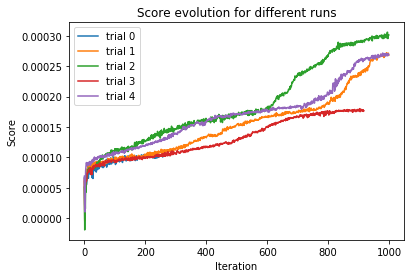

In [35]:
plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different runs');

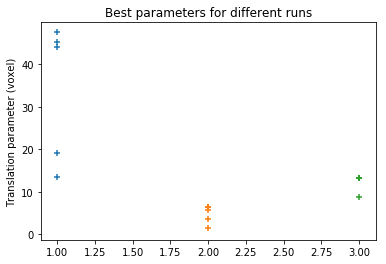

In [36]:
T_all_trials = np.array(T_all_trials)
plt.scatter(np.ones((T_all_trials.shape[0],)), T_all_trials[:, 3], marker='+');
plt.scatter(2*np.ones((T_all_trials.shape[0],)), T_all_trials[:, 7], marker='+');
plt.scatter(3*np.ones((T_all_trials.shape[0],)), T_all_trials[:, 11], marker='+');
plt.ylabel('Translation parameter (voxel)');
plt.title('Best parameters for different runs');

Best trial: 2
[[  0.88055505   0.35142873   0.31799474  47.53006754]
 [ -0.1729659    0.86296374  -0.47473822   5.63129545]
 [ -0.44125458   0.36303089   0.82067226  13.28388286]]


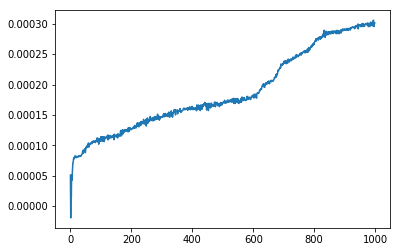

0.000305761858666 0.000301352471359


In [38]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 0
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();
print max(scores), scores[-1]

# Draw Results

In [42]:
t = time.time()

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
#                                       classifier_setting_m=classifier_setting,
#                                       classifier_setting_f=classifier_setting,
#                                       warp_setting=warp_setting,
#                                       param_suffix=structure,
#                                       trial_idx=trial_idx)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
([1,0,0,0,0,1,0,0,0,0,1,0], 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)


# Read global tx
global_transformed_moving_structure_vol = \
DataManager.load_transformed_volume(stack_m=stack_moving, stack_f=stack_fixed,
                                    classifier_setting_m=classifier_setting,
                                    classifier_setting_f=classifier_setting,
                                    warp_setting=upstream_warp_setting, 
                                    trial_idx=upstream_trial_idx,
                                    structure=structure)

# Transform
local_transformed_moving_structure_vol = transform_volume(vol=global_transformed_moving_structure_vol, 
                                         global_params=local_params, 
                                         centroid_m=centroid_m, centroid_f=centroid_f,
                                         xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

#         # Save
#         local_transformed_moving_structure_fn = \
#         DataManager.get_transformed_volume_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                     classifier_setting_m=classifier_setting,
#                                                     classifier_setting_f=classifier_setting,
#                                                     warp_setting=warp_setting,
#                                                     trial_idx=trial_idx,
#                                                     structure=structure)

#         create_if_not_exists(os.path.dirname(local_transformed_moving_structure_fn))
#         bp.pack_ndarray_file(local_transformed_moving_structure_vol, local_transformed_moving_structure_fn)

sys.stderr.write('Transform: %.2f seconds.\n' % (time.time() - t))

Transform: 3.97 seconds.


In [43]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
# levels = [0.5]
level_colors = {level: (int(level*255),0,0) for level in levels}

0 861 0 529 103 469


Error loading scoremap for section 178


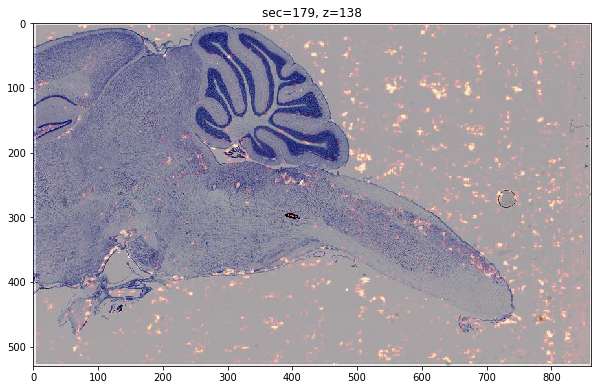

Error loading scoremap for section 180


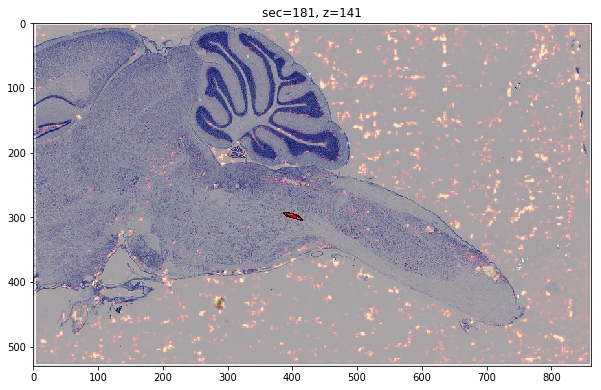

Error loading scoremap for section 182


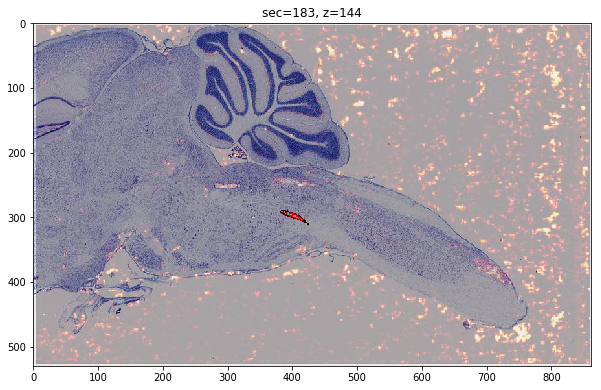

Error loading scoremap for section 184


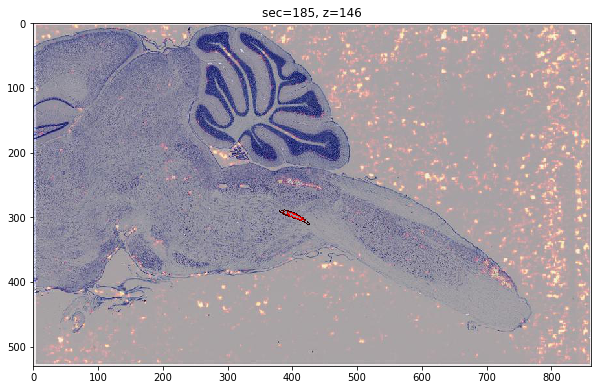

Error loading scoremap for section 186


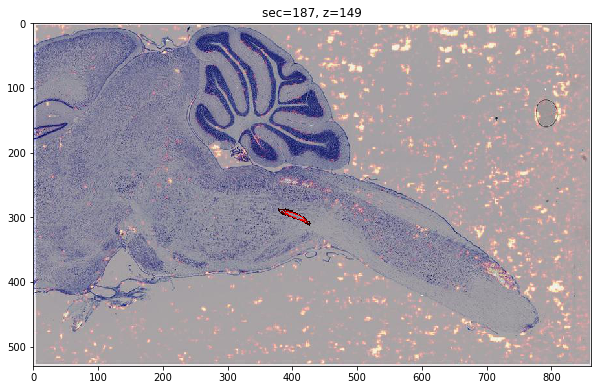

Error loading scoremap for section 188


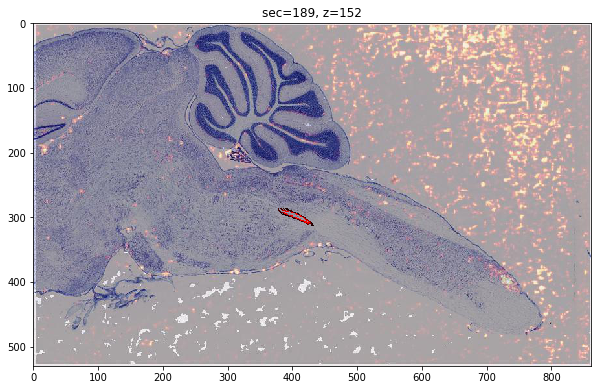

Error loading scoremap for section 190


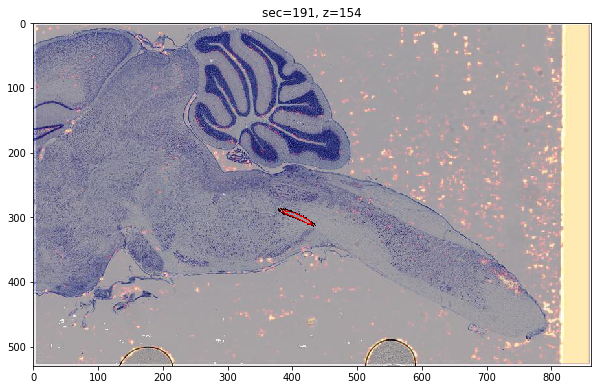

Error loading scoremap for section 192


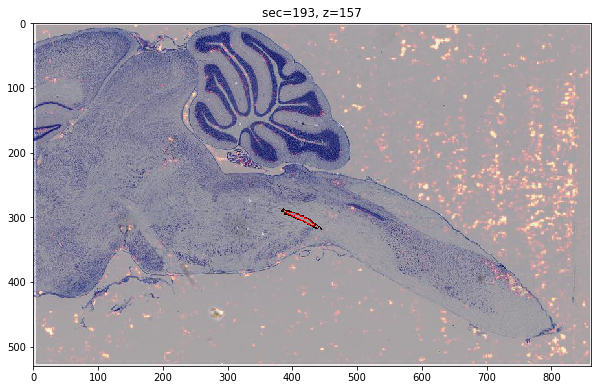

Error loading scoremap for section 194


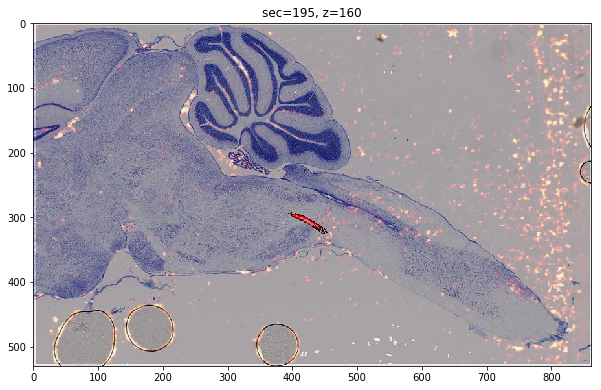

Error loading scoremap for section 196


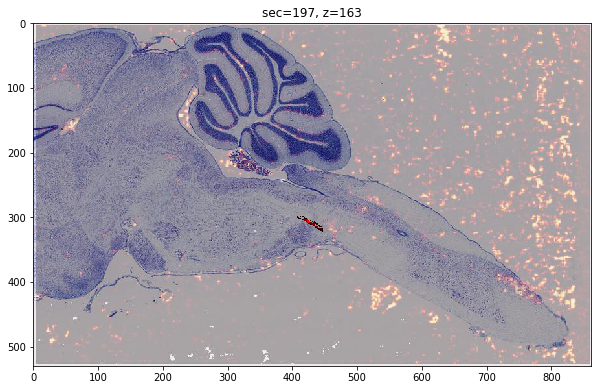

In [44]:
# Generate overlay visualization

# estimate mapping between z and section
# downsample_factor = 32
# xy_pixel_distance_downsampled = XY_PIXEL_DISTANCE_LOSSLESS * downsample_factor
# voxel_z_size = SECTION_THICKNESS / xy_pixel_distance_downsampled

# For getting correct contour location
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_original_volume_bbox(stack=stack_fixed, vol_type='score', structure='7N', 
                             downscale=32, classifier_setting=classifier_setting)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate atlas overlay image for every section

zf, zl = bbox_3d(local_transformed_moving_structure_vol)[4:]
sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

for sec in range(sec_first, sec_last+1):
# for sec in [181]:
    
    if is_invalid(stack=stack_fixed, sec=sec):
        continue
    
#     img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#     img = imread(img_fn)
    
    try:
        img = imread(DataManager.get_scoremap_viz_filepath(stack=stack_fixed, downscale=32, section=sec, 
                                                           structure=convert_to_original_name(structure), 
                                                           setting=classifier_setting))
    except:
        sys.stderr.write('Error loading scoremap for section %d\n' % sec)
        continue
        
#     img = img[::4, ::4]
    
    viz = img.copy()
    
    z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(z1)
    
    # Find moving volume annotation contours
    c = 0
    vol = local_transformed_moving_structure_vol
    for level in levels:
        cnts = find_contours(vol[..., z], level=level) # rows, cols
        c += len(cnts)
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:,::-1] + (xmin_vol_f, ymin_vol_f)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
    if c > 0:    
        plt.figure(figsize=(10,10));
        plt.title("sec=%d, z=%d" % (sec, z));
        plt.imshow(viz);
        plt.show();
    
#     viz_fp = DataManager.get_alignment_viz_filepath(stack_m=stack_moving,
#                                             stack_f=stack_fixed,
#                                             classifier_setting_m=classifier_setting,
#                                             classifier_setting_f=classifier_setting,
#                                             warp_setting=warp_setting,
#                                           section=sec)
    
#     create_if_not_exists(os.path.dirname(viz_fp))
#     imsave(viz_fp, viz)

In [154]:
display_image(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/registration/tmp.jpg